In [ ]:
pip install sklearn matplotlib

In [2]:
pip install transformers

In [ ]:
nltk.download('punkt')

In [3]:
import os
import json
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors


       File Name  Token Length
0    82_fox.json           481
1    66_hpo.json           756
2    90_nyt.json           938
3    46_nyt.json           437
4    98_nyt.json           862
..           ...           ...
295  66_fox.json           385
296  42_NYT.json           438
297  89_hpo.json           717
298  26_fox.json          1167
299  79_fox.json          1255

[300 rows x 2 columns]

Statistical Measures:
Mean Token Length: 858.17
Median Token Length: 818.5
Maximum Token Length: 2378
Minimum Token Length: 255


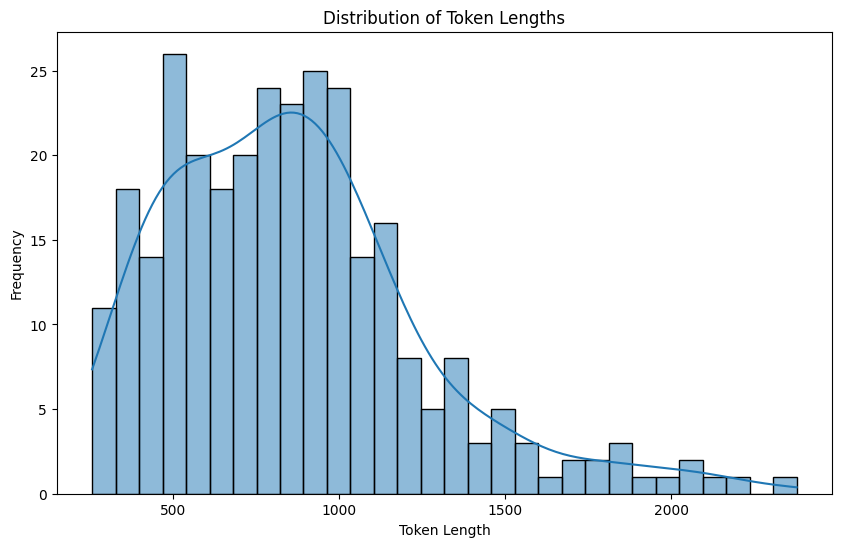

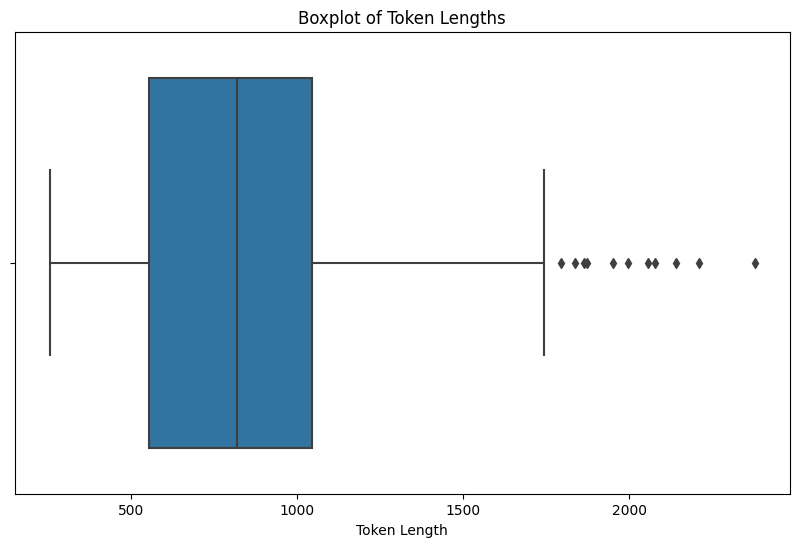

In [12]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Path to the data folder
data_folder = '/content/data'

# Lists to store file names and their corresponding token lengths
file_names = []
token_lengths = []

# Processing each file
all_files = [os.path.join(data_folder, file) for file in os.listdir(data_folder) if file.endswith('.json')]
for file in all_files:
    with open(file, 'r') as f:
        article = json.load(f)

    title = article['title']
    body = " ".join([sent['sentence'] for sent in article['body']])
    full_text = title + " " + body

    # Calculate total number of tokens
    total_tokens = len(tokenizer.encode(full_text, add_special_tokens=True))

    # Append results to lists
    file_names.append(os.path.basename(file))
    token_lengths.append(total_tokens)

# Create a DataFrame
df = pd.DataFrame({
    'File Name': file_names,
    'Token Length': token_lengths
})

# Display the DataFrame
print(df)

# Calculate and display statistical measures
print("\nStatistical Measures:")
print(f"Mean Token Length: {df['Token Length'].mean()}")
print(f"Median Token Length: {df['Token Length'].median()}")
print(f"Maximum Token Length: {df['Token Length'].max()}")
print(f"Minimum Token Length: {df['Token Length'].min()}")

# Plotting
plt.figure(figsize=(10, 6))
sns.histplot(df['Token Length'], bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Token Length'])
plt.title('Boxplot of Token Lengths')
plt.xlabel('Token Length')
plt.show()

In [4]:
# Define stance mapping
stance_mapping = {0: "left", 1: "center", 2: "right"}

def chunk_text_by_tokens(text, max_tokens):
    # Tokenize the text and get the token ids
    token_ids = tokenizer.encode(text, add_special_tokens=False)

    # Initialize chunks
    chunks = []
    current_chunk_token_ids = []

    for token_id in token_ids:
        if len(current_chunk_token_ids) + 1 > max_tokens:
            # Convert token ids to text and add to chunks
            chunks.append(tokenizer.decode(current_chunk_token_ids))
            current_chunk_token_ids = [token_id]
        else:
            current_chunk_token_ids.append(token_id)

    # Add last chunk
    if current_chunk_token_ids:
        chunks.append(tokenizer.decode(current_chunk_token_ids))

    return chunks

# Function to chunk text by sentences
def chunk_text_by_sentences(text, max_tokens):
    sentences = sent_tokenize(text)
    token_chunks = []
    current_chunk = []

    for sentence in sentences:
        sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
        if len(current_chunk) + len(sentence_tokens) > max_tokens:
            token_chunks.append(current_chunk)
            current_chunk = sentence_tokens
        else:
            current_chunk.extend(sentence_tokens)

    if current_chunk:
        token_chunks.append(current_chunk)

    return token_chunks

In [5]:
# Function to get model prediction
def get_model_prediction(text_chunks):
    probs_list = []

    for chunk in text_chunks:
        # Tokenize each chunk
        inputs = tokenizer(chunk, return_tensors='pt', padding='max_length', truncation=True, max_length=512)

        # Pass the inputs to the model
        outputs = model(**inputs)
        logits = outputs.logits
        probs = logits.softmax(dim=-1).squeeze().tolist()
        probs_list.append(probs)

    # Calculate the median probabilities
    probs_array = np.array(probs_list)
    median_probs = np.median(probs_array, axis=0)
    predicted_stance = stance_mapping[np.argmax(median_probs)]

    return predicted_stance

In [6]:
# Load JSON files
data_dir = "./data"
all_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.json')]

# DataFrame for storing additional information
info_df = pd.DataFrame(columns=['FileName', 'NumTokens', 'FullText'])

Processing with max_length = 128


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 128: 0.2833
              precision    recall  f1-score   support

      center       0.56      0.03      0.07       144
        left       0.24      0.20      0.22        81
       right       0.29      0.85      0.43        75

    accuracy                           0.28       300
   macro avg       0.36      0.36      0.24       300
weighted avg       0.40      0.28      0.20       300



<Figure size 1000x700 with 0 Axes>

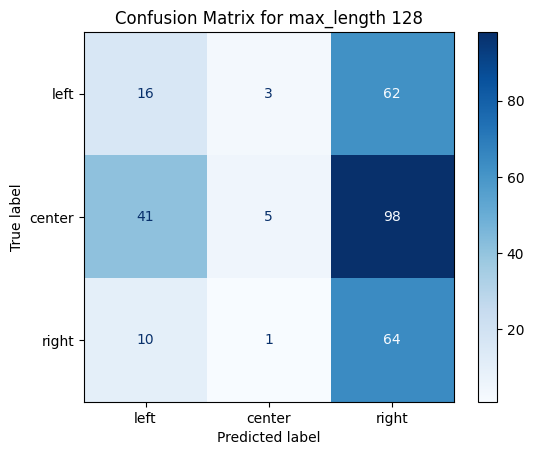

Processing with max_length = 256


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 256: 0.3367
              precision    recall  f1-score   support

      center       0.62      0.19      0.30       144
        left       0.23      0.22      0.22        81
       right       0.31      0.73      0.44        75

    accuracy                           0.34       300
   macro avg       0.39      0.38      0.32       300
weighted avg       0.44      0.34      0.31       300



<Figure size 1000x700 with 0 Axes>

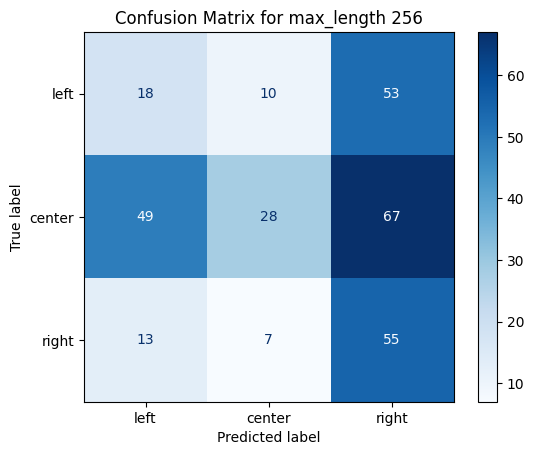

Processing with max_length = 512


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 512: 0.3967
              precision    recall  f1-score   support

      center       0.51      0.46      0.48       144
        left       0.24      0.20      0.21        81
       right       0.36      0.49      0.42        75

    accuracy                           0.40       300
   macro avg       0.37      0.38      0.37       300
weighted avg       0.40      0.40      0.39       300



<Figure size 1000x700 with 0 Axes>

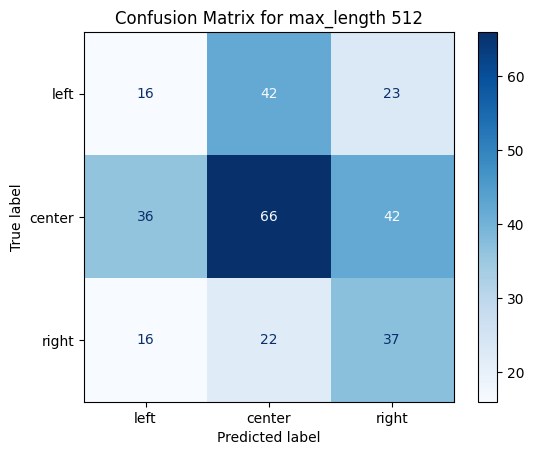

Processing with max_length = 1024


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 1024: 0.4500
              precision    recall  f1-score   support

      center       0.49      0.65      0.56       144
        left       0.24      0.16      0.19        81
       right       0.52      0.39      0.44        75

    accuracy                           0.45       300
   macro avg       0.42      0.40      0.40       300
weighted avg       0.43      0.45      0.43       300



<Figure size 1000x700 with 0 Axes>

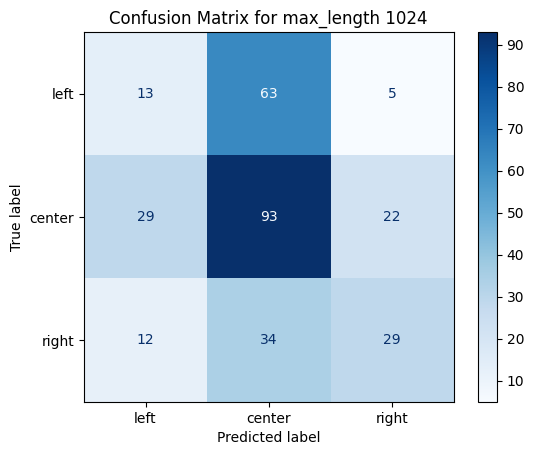

Processing with max_length = 2048


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 2048: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

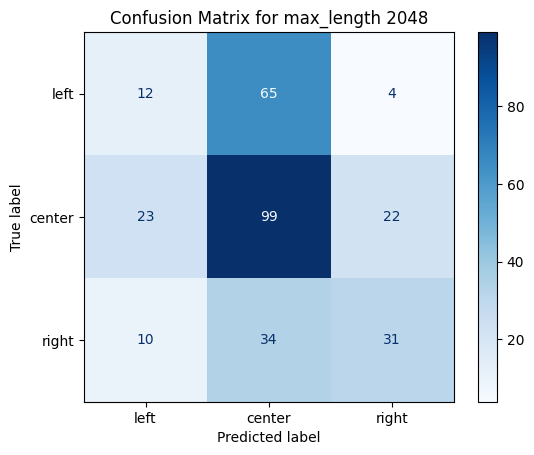

In [ ]:
# Iterate over different max lengths
for max_length in [128, 256, 512, 1024, 2048]:
    print(f"Processing with max_length = {max_length}")
    true_labels = []
    predicted_labels = []

    for file in tqdm(all_files):
        with open(file, 'r') as f:
            article = json.load(f)

        title = article['title']
        body = " ".join([sent['sentence'] for sent in article['body']])
        full_text = title + " " + body
        true_labels.append(article['article-level-annotations']['stance'].lower())

        # Chunking method: by tokens or by sentences
        text_chunks = chunk_text_by_tokens(full_text, max_length)
        # text_chunks = chunk_text_by_sentences(full_text, max_length)

        predicted_labels.append(get_model_prediction(text_chunks))

        new_row = pd.DataFrame({
            'FileName': [os.path.basename(file)],
            'NumTokens': [len(tokenizer.encode(full_text))],
            'FullText': [full_text]
        })
        info_df = pd.concat([info_df, new_row], ignore_index=True)

    # Evaluate and plot
    df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for max_length {max_length}: {accuracy:.4f}")
    print(classification_report(true_labels, predicted_labels))

    ordered_labels = ['left', 'center', 'right']
    matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=ordered_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ordered_labels)
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for max_length {max_length}")
    plt.show()

In [10]:
def get_model_prediction(text_chunks):
    probs_list = []

    for chunk in text_chunks:
        # Convert token ids to text
        chunk_text = tokenizer.decode(chunk)

        # Tokenize the text
        inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)


        # Pass the inputs to the model
        outputs = model(**inputs)
        logits = outputs.logits
        probs = logits.softmax(dim=-1).squeeze().tolist()
        probs_list.append(probs)

        # Calculate the median probabilities
        probs_array = np.array(probs_list)
        median_probs = np.median(probs_array, axis=0)
        predicted_stance = stance_mapping[np.argmax(median_probs)]

        return predicted_stance

Processing with max_length = 128


  0%|          | 0/300 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (756 > 512). Running this sequence through the model will result in indexing errors


Accuracy for max_length 128: 0.4533
              precision    recall  f1-score   support

      center       0.50      0.71      0.58       144
        left       0.20      0.10      0.13        81
       right       0.48      0.35      0.40        75

    accuracy                           0.45       300
   macro avg       0.39      0.38      0.37       300
weighted avg       0.41      0.45      0.42       300



<Figure size 1000x700 with 0 Axes>

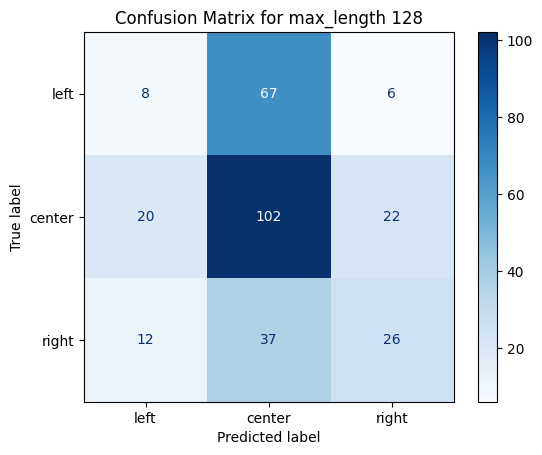

Processing with max_length = 256


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 256: 0.4600
              precision    recall  f1-score   support

      center       0.49      0.69      0.57       144
        left       0.22      0.12      0.16        81
       right       0.55      0.39      0.45        75

    accuracy                           0.46       300
   macro avg       0.42      0.40      0.39       300
weighted avg       0.43      0.46      0.43       300



<Figure size 1000x700 with 0 Axes>

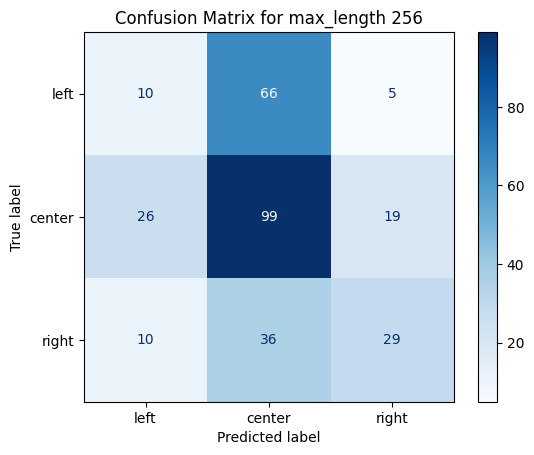

Processing with max_length = 512


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 512: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

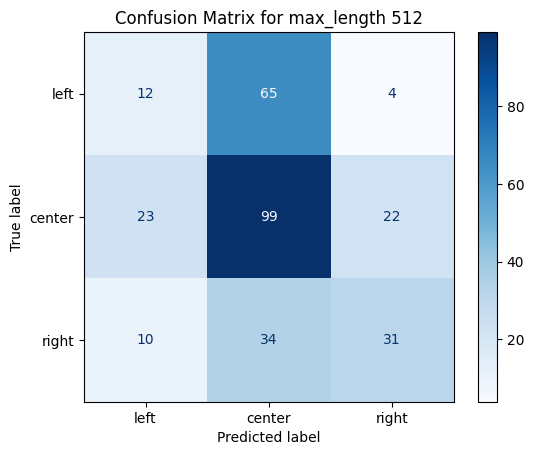

Processing with max_length = 1024


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 1024: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

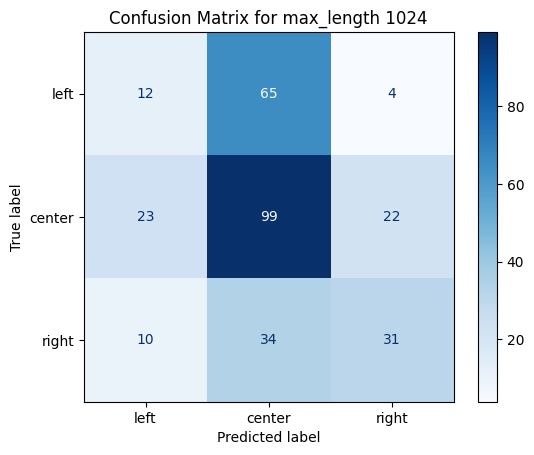

Processing with max_length = 2048


  0%|          | 0/300 [00:00<?, ?it/s]

Accuracy for max_length 2048: 0.4733
              precision    recall  f1-score   support

      center       0.50      0.69      0.58       144
        left       0.27      0.15      0.19        81
       right       0.54      0.41      0.47        75

    accuracy                           0.47       300
   macro avg       0.44      0.42      0.41       300
weighted avg       0.45      0.47      0.45       300



<Figure size 1000x700 with 0 Axes>

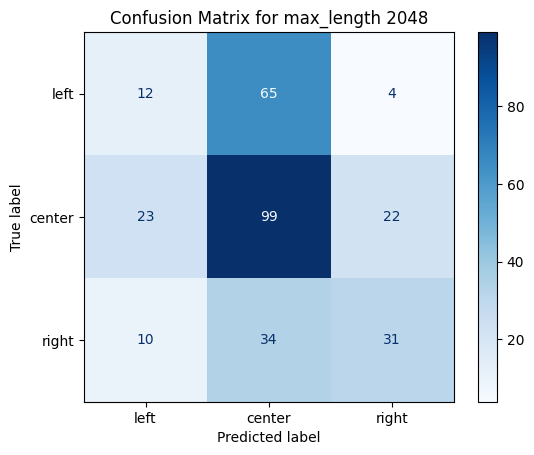

In [11]:
# Iterate over different max lengths
for max_length in [128, 256, 512, 1024, 2048]:
    print(f"Processing with max_length = {max_length}")
    true_labels = []
    predicted_labels = []

    for file in tqdm(all_files):
        with open(file, 'r') as f:
            article = json.load(f)

        title = article['title']
        body = " ".join([sent['sentence'] for sent in article['body']])
        full_text = title + " " + body
        true_labels.append(article['article-level-annotations']['stance'].lower())

        # Chunking method: by tokens or by sentences
        # text_chunks = chunk_text_by_tokens(full_text, max_length)
        text_chunks = chunk_text_by_sentences(full_text, max_length)

        predicted_labels.append(get_model_prediction(text_chunks))

        new_row = pd.DataFrame({
            'FileName': [os.path.basename(file)],
            'NumTokens': [len(tokenizer.encode(full_text))],
            'FullText': [full_text]
        })
        info_df = pd.concat([info_df, new_row], ignore_index=True)

    # Evaluate and plot
    df = pd.DataFrame({'True_Labels': true_labels, 'Predicted_Labels': predicted_labels})
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy for max_length {max_length}: {accuracy:.4f}")
    print(classification_report(true_labels, predicted_labels))

    ordered_labels = ['left', 'center', 'right']
    matrix = confusion_matrix(df['True_Labels'], df['Predicted_Labels'], labels=ordered_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=ordered_labels)
    plt.figure(figsize=(10, 7))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for max_length {max_length}")
    plt.show()